Advanced Statistics for Physics Analysis 2022/23

Antonio Feltrin, Student ID 2097126

antonio.feltrin@studenti.unipd.it

# Lab 6: Monte Carlo (II)

Monte Carlo Markov Chain, Vaccine analysis

In [1]:
library(tibble)
library(rjags)
library(coda)
library(spatstat)
library(ggplot2)
library(dplyr)
library(lubridate)


Loading required package: coda

Linked to JAGS 4.3.2

Loaded modules: basemod,bugs

Loading required package: spatstat.data

Loading required package: spatstat.geom

spatstat.geom 3.2-1

Loading required package: spatstat.random

spatstat.random 3.1-5

Loading required package: spatstat.explore

Loading required package: nlme

spatstat.explore 3.2-1

Loading required package: spatstat.model

Loading required package: rpart

spatstat.model 3.2-4

Loading required package: spatstat.linnet

spatstat.linnet 3.1-1


spatstat 3.0-6 
For an introduction to spatstat, type ‘beginner’ 



Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
th_vs_MC <- function(xlims=c(0, 1),post,chain,name) {
    
    sa <- which(chain[,2]>=min(xlims) & chain[,2]<=max(xlims))

    hist <- hist(chain[sa ,2], breaks =seq(from=min(xlims), to=max(xlims),
    length.out=100), plot=FALSE)
    dh <- min(diff(hist$breaks))
    dx <- dh/5
    Zhist <- sum(hist$counts ) * dh # integrate histo: sum {f(x) Delta_x}
    
    x <- seq(xlims[1],xlims[2],by=dx)
    y <- post(x)
    sumy <- integrate(post,lower=-10,upper=10)
    y <- y/sumy$value
    
    plot(hist$breaks , c(hist$counts/Zhist ,0), #plot normalized histogram onto theoretical posterior
    col='navy', type="s", lwd=2, lty=5,
    yaxs="i", ylim=c(0, 1.2*max(y)),
    xlim=1.1*c(min(x),max(x)),
    xlab= expression(theta), 
    main=name,
    ylab= expression(paste('f(',theta ,')', sep='')))
    
    lines(x, y, col='firebrick 3', lwd=1.5, lty=1)

    leg.labels = c('analytical', 'MCMC')
    leg.ltype = c(1, 5)
    leg.colors = c('firebrick 3','navy')
    legend("topright", inset =.05, bty='n', legend = leg.labels, 
           lty=leg.ltype , col=leg.colors , lwd = 2)
    grid()

}

In [3]:
# Parameters :
# func : a function whose first argument is a real vector of parameters
# theta.init : the initial value of the Markov Chain (and of func)
# n.sample: number of required samples
# sigma : standard deviation of the gaussian MCMC sampling pdf
mc_nsample <- 10^4
mc_sigma <- 1

metropolis.1dim <- function (func, theta.init=0., n.sample=mc_nsample, 
                              sigma=mc_sigma, burn.in=0, thin=1,walker=FALSE) {
    theta.cur <- theta.init
    func.Cur <- log10(func(theta.cur))
    chain <- matrix(data=NA , nrow=n.sample , ncol=2+1) 
    n.accept <- 0
    rate.accept <- 0.0
    
    for (n in 1:n.sample) {
        theta.prop <- ifelse(walker==FALSE,rnorm(n=1, mean=theta.cur, sd=sigma), rnorm(n=1, mean = 0, sd=1))
        func.Prop <- log10(func(theta.prop))
        logMR <- func.Prop - func.Cur # Log10 of the Metropolis ratio
        chain[n, 3] <- 0
        if ( logMR >=0 || logMR >log10(runif(1)) ) { #logMR>0 : prop/cur > 1; else accept anyway but if > rng thresh
            theta.cur <- theta.prop
            func.Cur <- func.Prop
            n.accept <- n.accept + 1
            chain[n, 3] <- 1
        }
        chain[n, 1] <- func.Cur
        chain[n, 2] <- theta.cur
    }
    
    #apply burn-in & thinning; still has to compute the whole chain beforehand
    chain <- chain[(burn.in+1):nrow(chain),]
    chain <- chain[seq(1,nrow(chain),thin),]

    return(chain)
}

to.coda <- function(chain,infopoint=FALSE){
    coda.chain <- as.mcmc(chain[,2])
        #summary & info
        if (infopoint==TRUE){
            cat('Acceptance rate =',sum(chain[,3])/length(chain),'\n')
            print(summary(coda.chain))
        }
    return(coda.chain)
    }

In [4]:
lz = 1:1e3
lz = lz[100:1e3]
lz = lz[seq(1,length(lz),10)]
length(lz)

[1] 91

### Exercise 1
given the following un-normalized posterior distribution: 

$$ g(\theta|x) \propto \frac{1}{2}exp\Biggl(-\frac{(\theta+3)^2}{2}\Biggr) + \frac{1}{2}exp\Biggl(-\frac{(\theta-3)^2}{2}\Biggr) $$

1. draw a Markov Chain from the posterior distribution using a Metropolis-Hastings algorithm

2. use a Norm (0, 1) as random-walk candidate density

3. plot the sampled distribution

4. analyze the chain with the ``CODA`` package and plot the chain autocorrelation

5. try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters?

#### 1.1

For this section I will adapt the code given in the slides ``Markov chain Monte Carlo`` of the course, combining it with functions from the ``CODA`` package. 

$$ g(\theta|x) \propto \frac{1}{2}exp\Biggl(-\frac{(\theta+3)^2}{2}\Biggr) + \frac{1}{2}exp\Biggl(-\frac{(\theta-3)^2}{2}\Biggr) $$

In [5]:
# function
set.seed(2097126)

post1 <- function(x){
    g1 <- 1/2 * exp(-((x+3)^2)/2) + 1/2 * exp(-((x-3)^2)/2)
    return(g1)
}

``CODA`` analysis

In [6]:
chain1 <- metropolis.1dim(func=post1,sigma=1,burn.in=1000,thin=10,theta.init=3,walker=TRUE)  
c.chain <- to.coda(chain1,infopoint=TRUE)

Acceptance rate = 0.1407407 

Iterations = 1:900
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 900 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
      -0.02302        1.67687        0.05590        0.06305 

2. Quantiles for each variable:

    2.5%      25%      50%      75%    97.5% 
-2.72920 -1.53213 -0.09574  1.52296  2.68760 



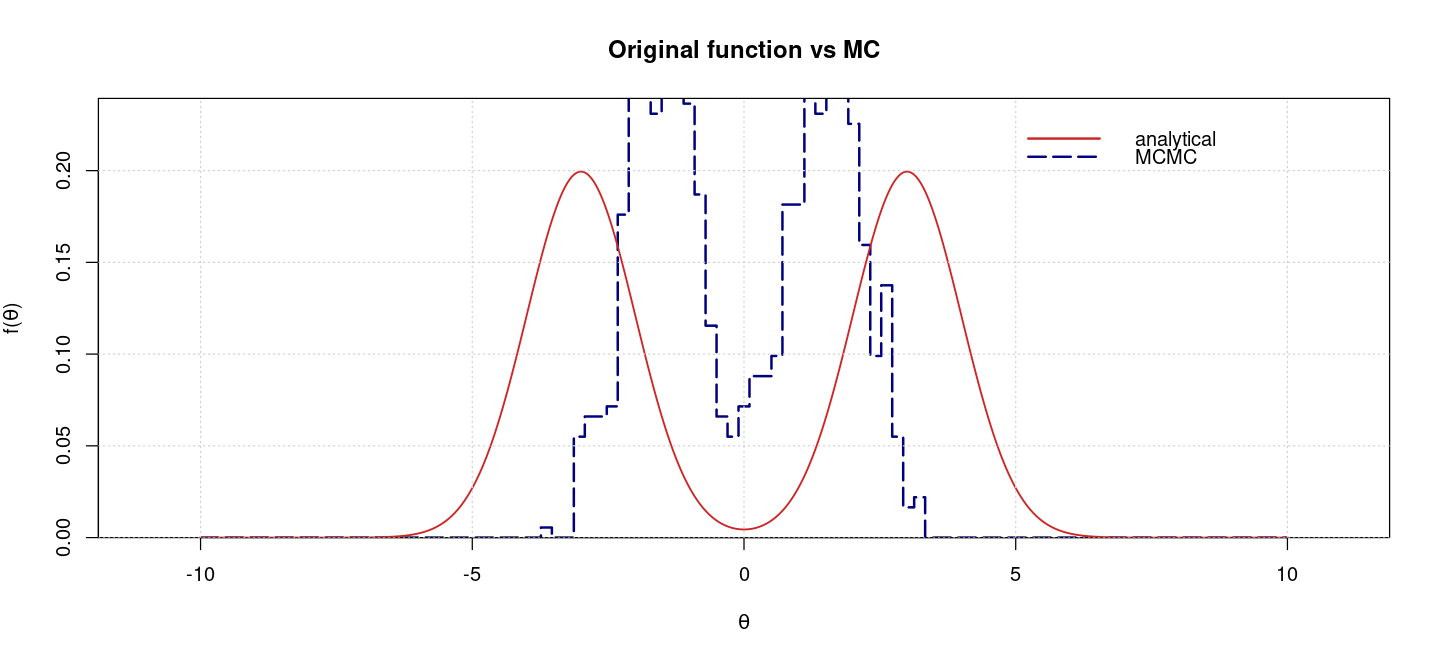

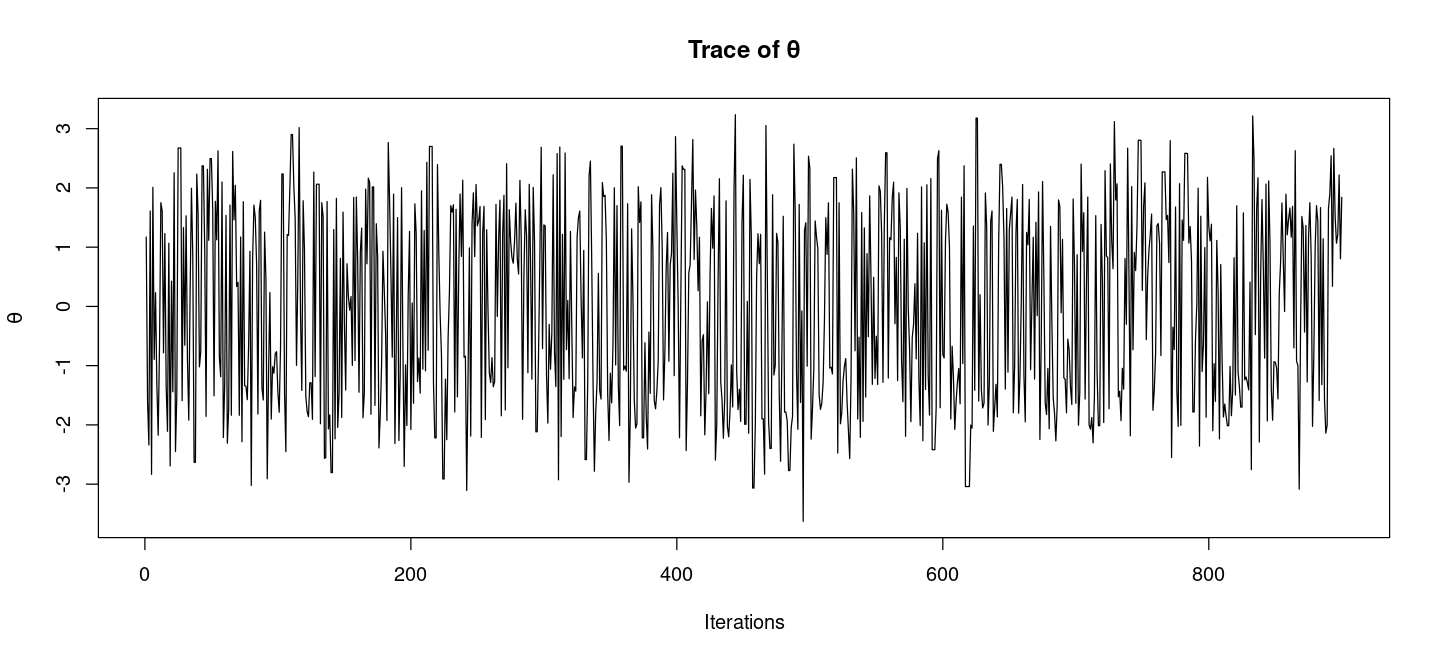

In [7]:
options(repr.plot.width=12, repr.plot.height=5.5)

th_vs_MC(c(-10,10),post1,chain1,name='Original function vs MC')

plot(c.chain, density=FALSE,main='Trace of θ',ylab=expression(theta))

Choosing a random walker of $\mu=1, \sigma=1$ is not appropriate, since the chain will be trapped almost surely in one of the two peaks. I resort to $\mu=\theta_{current}, \sigma = 4$, since there is a significant drop-off in the effective sizes for $\sigma <4$. The consequent lower acceptance rate is balanced by taking a lot of points in the chain ($10^5$).

Acceptance rate = 0.09213333 

Iterations = 1:10000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean             SD       Naive SE Time-series SE 
       0.09807        3.14780        0.03148        0.08833 

2. Quantiles for each variable:

  2.5%    25%    50%    75%  97.5% 
-4.535 -2.954  1.104  3.091  4.585 


Sigma = 8 : Effective size = 1269.943
Sigma = 4 : Effective size = 1110.623
Sigma = 2 : Effective size = 250.3579
Sigma = 1 : Effective size = 36.62695
Sigma = 0.5 : Effective size = 12.37653
Sigma = 0.05 : Effective size = 14.63503

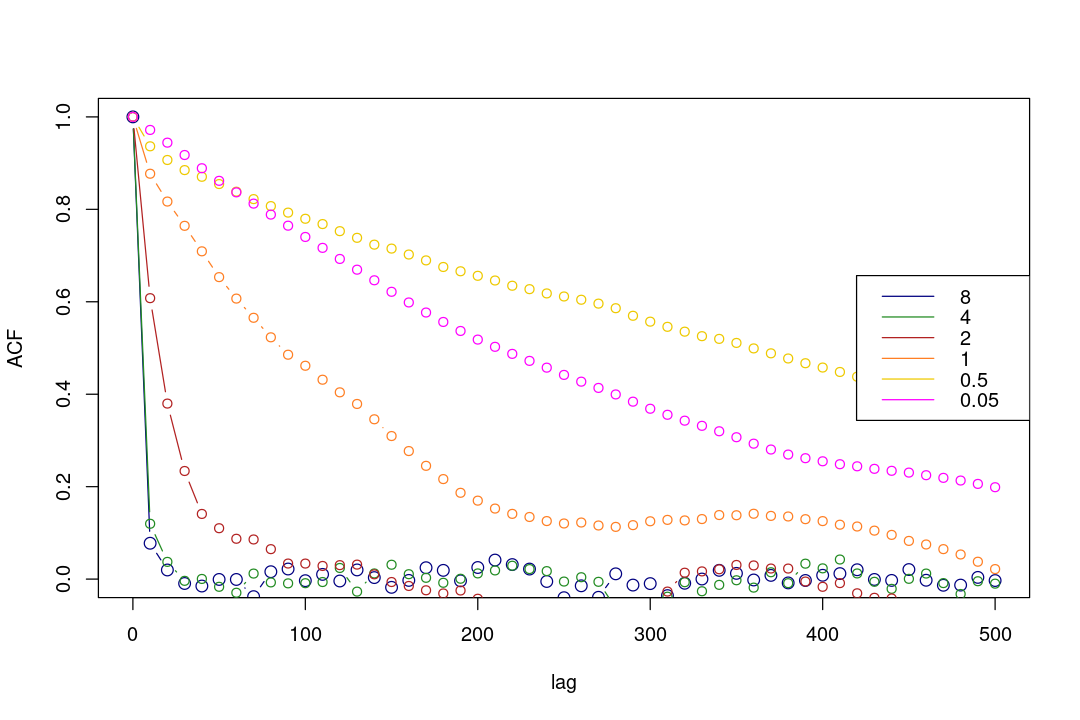

In [8]:
my.lags = seq(0,500,10)
mc_sigma = c(8,4,2,1,0.5,0.05)
ACFcols = c('navy','forestgreen','firebrick','chocolate1','gold2','magenta')
options(repr.plot.width=9, repr.plot.height=6)


chainb <- to.coda(metropolis.1dim(func=post1,sigma=8),infopoint=TRUE)
y1 <- autocorr(chainb, lags=my.lags)

plot(my.lags, y1, ylim=c(0,1),
type='b',col=ACFcols[1],
xlab='lag', ylab='ACF', cex=1.3)

cat('\nSigma =',mc_sigma[1],': Effective size =', effectiveSize(chainb))

for (i in 2:6){
    chain1b <- to.coda(metropolis.1dim(func= post1, sigma=mc_sigma[i]),infopoint=FALSE)
    y1b <- autocorr(chain1b, lags=my.lags)
    lines(my.lags , y1b, ylim=c(0,1), type='b',col=ACFcols[i])
    cat('\nSigma =',mc_sigma[i],': Effective size =',effectiveSize(chain1b))
    }

legend('right',legend=mc_sigma,
       col=ACFcols,lt=1)

#### 1.5
Now we proceed to search for the best ``thin``,``burn.in`` parameters with $\sigma=4$.

In [9]:
thin.list <- c(1,10,100,1000)
burn.list <- c(1,100,1000,5000)
length(thin.list)

[1] 4

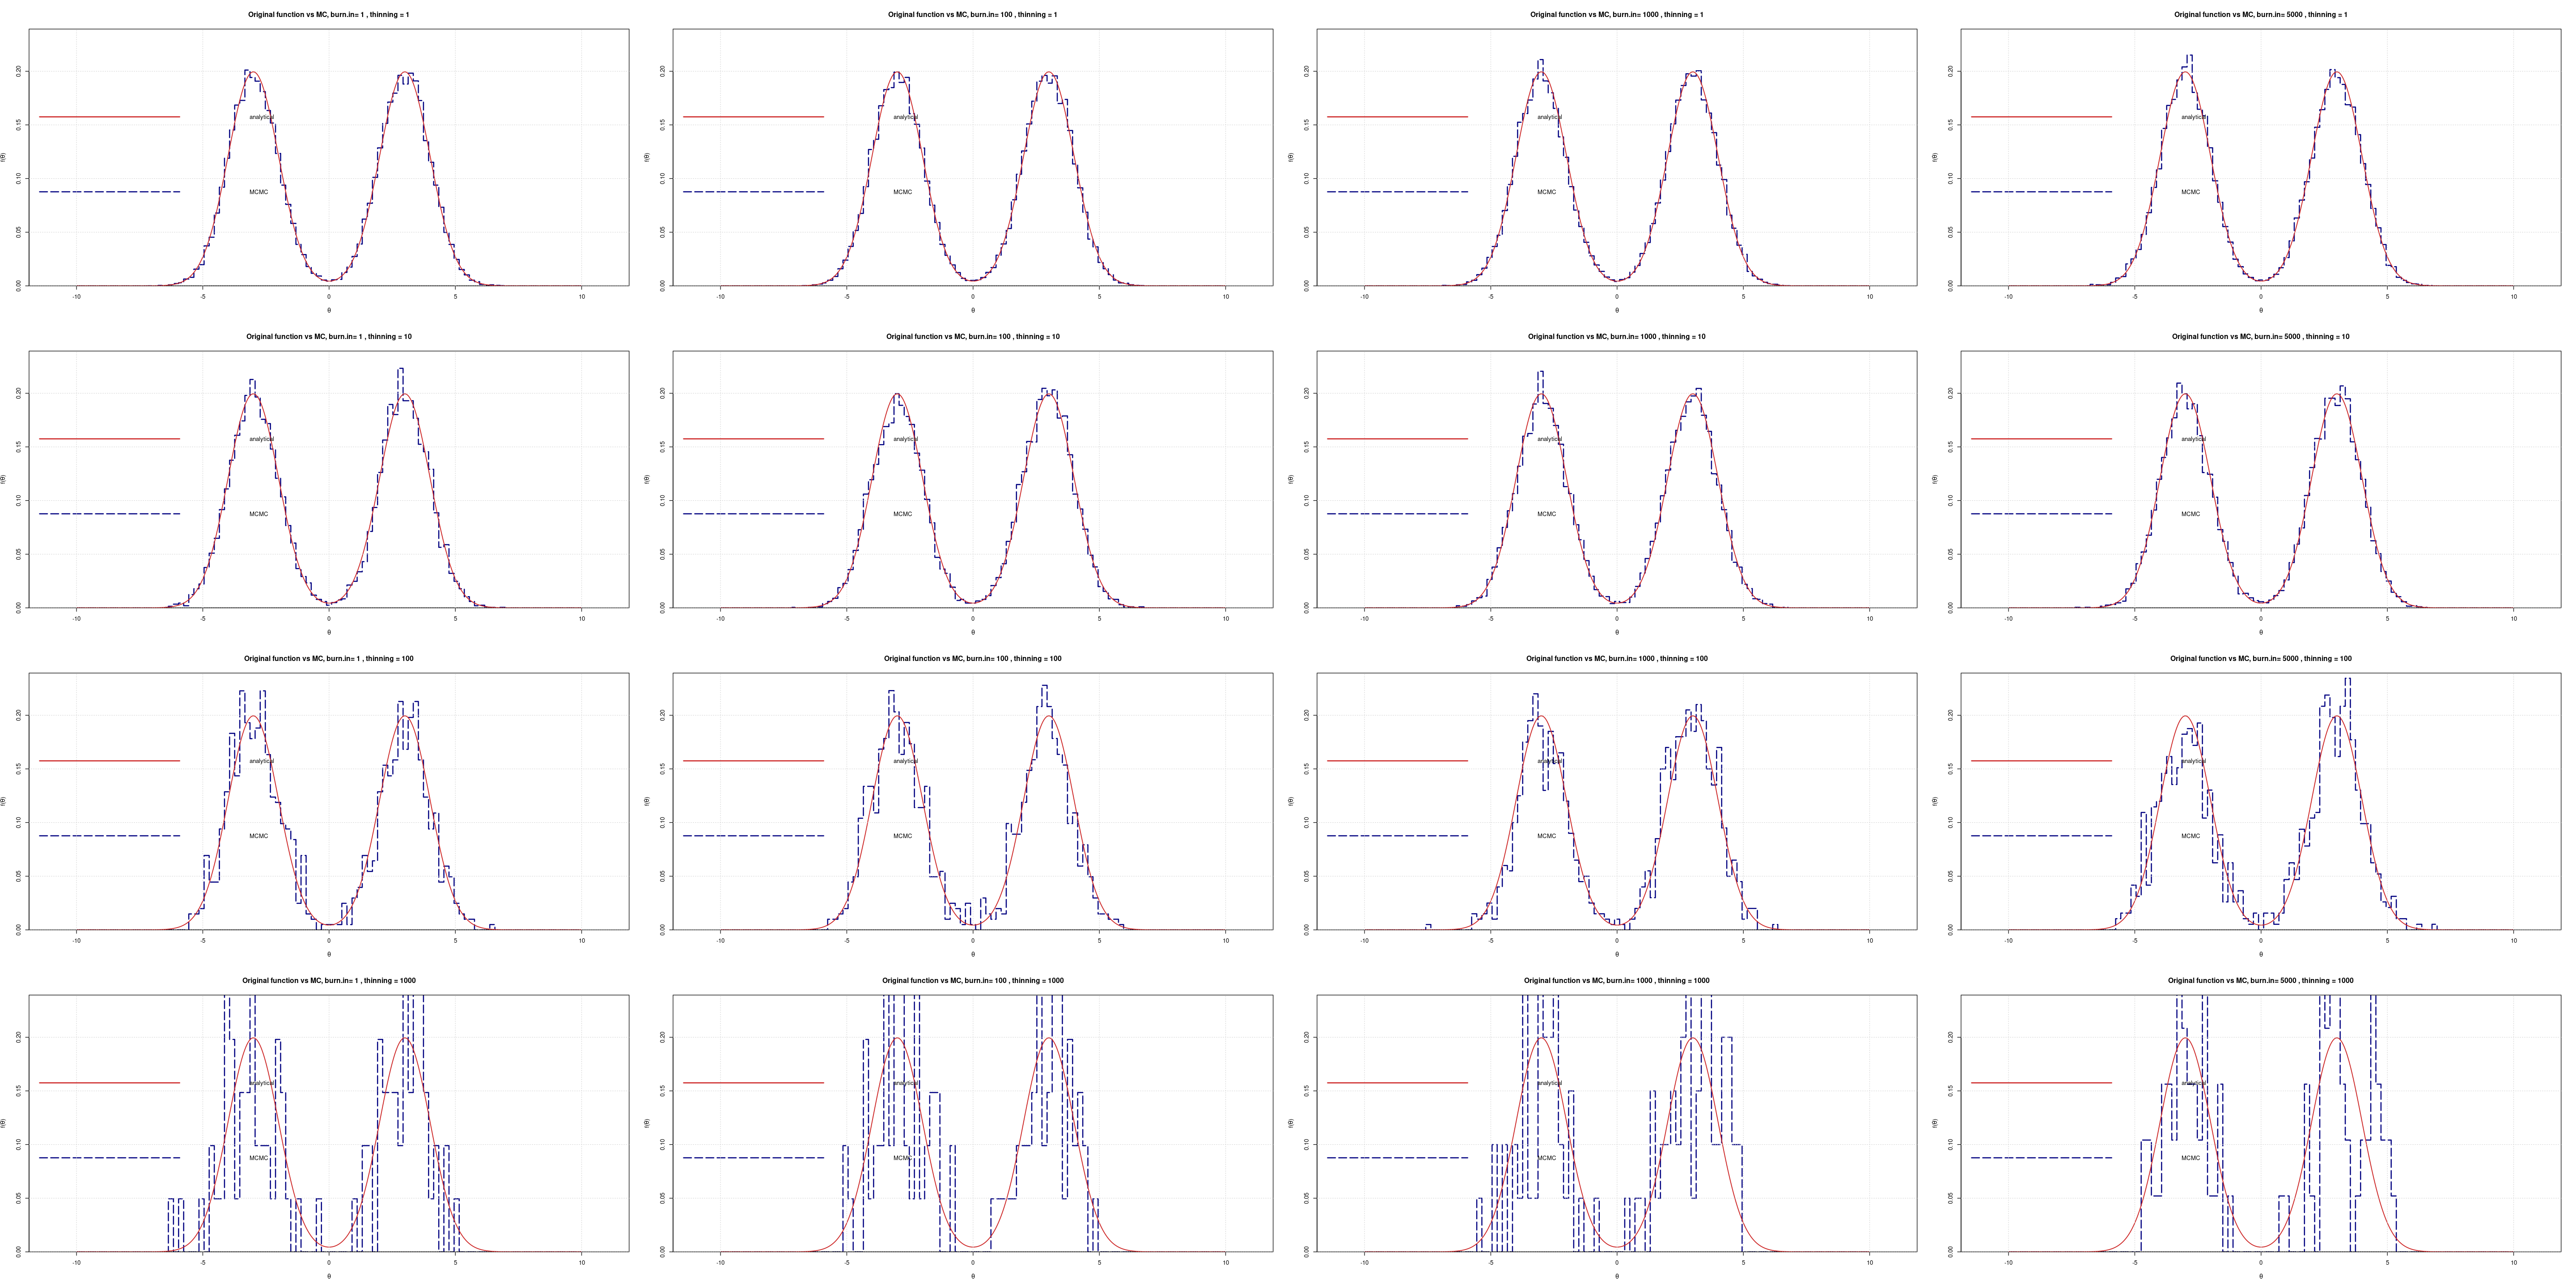

In [10]:
par(mfrow=c(4,4))
options(repr.plot.width=48, repr.plot.height=24)

for (t in 1:length(thin.list)){
    for (b in 1:length(burn.list)){
           th_vs_MC(c(-10,10),post1,metropolis.1dim(func=post1,n.sample = 1e5,theta.init=3,
            burn.in=burn.list[b],thin=thin.list[t],sigma=4),
            name=paste('Original function vs MC, burn.in=',burn.list[b],', thinning =',thin.list[t]))
        }
    }

Problems seem to arise when shifting towards greater thinning values. Coupled with a low acceptance rate, this means that there are simply not enough data in the chain to reproduce the original function. The best compromise should be around `burn.in`$=1000$, `thinn`$=10$.

# Exercise 2
the European Medicines Agency (EMA) has authorized a list of COVID-19 vaccines, after having performed a scientific evaluation of the vaccines efficacy. The following vaccines are currently authorized for use in the European Union:
1. Comirnaty (BioNTech and Pfizer)
2. VCOVID-19 Vaccine Valneva
3. Nuvaxovid (Novavax
4. Pikevax (Moderna)
5. Vaxzeviria (AstraZeneca)
6. Jcovden (Janssen)
7. VidPrevtyn Beta (Sanofi Pasteur)
8. Bimervax, previously COVID-19 Vacxcine HIPRA (HIPRA Human Health S.L.U.)

Analyze the initial test data reported on the EMA Web site for the following early Vaccines:

1. [AstraZeneca](https://www.ema.europa.eu/en/medicines/human/EPAR/vaxzevria)
2. [Jcovden](https://www.ema.europa.eu/en/documents/overview/jcovden-previously-covid-19-vaccine-janssen-epar-medicine-overview_en.pdf)
3. [Moderna](https://www.ema.europa.eu/en/documents/overview/spikevax-previously-covid-19-vaccine-moderna-epar-medicine-overview_en.pdf)

and create a Markow Chain Monte Carlo `JAGS` or `stan` for the efficacy of each Vaccine. Infere the $95\%$
credibility interval.

ToDo: 
1. I have 'frequentist' approach + efficacy claim. 
2. So I run `jags` and get the most probable infection rates for the vaccine and the placebo $I_v$, $I_p$ 
3. I compute the efficacy as $E = (I_p-I_v)I_p$

Below, I define the function for the `JAGS` simulation.

In [11]:
#AstraZeneca 
A.tot.vax <- 5258 #vaccinate 
A.pos.vax <- 64
A.tot.plb <- 5210 #placebo 
A.pos.plb <- 154
# claimed efficiency: 59.5%
EA.claim <- 0.595

In [12]:
#Jcovden
J.tot.vax <- 19630
J.pos.vax <- 116
J.tot.plb <- 19691
J.pos.plb <- 348
# claimed efficiency: 67%
EJ.claim <- 0.67

In [13]:
#Moderna; claimed efficiency: 94.1%
M.tot.vax <- 14134
M.pos.vax <- 11
M.tot.plb <- 14073
M.pos.plb <- 185
# claimed efficiency: 94.1%
EM.claim <- 0.941

The content of the `vacc3.bug` script:
```
model {
	#likelihood for vaccinated people
	for (i in 1:n[1]) {
		Xv[i] ~ dbern(p1);
	}
	
	#likelihood for placebo'ed people
	for (i in 1:n[2]) {
		Xp[i] ~ dbern(p2);
	}
	
	#prior; same for both vaccine, placebo
	p1 ~ dbeta(4,40);
	p2 ~ dbeta(4,40);
	
}
```

In [14]:
test.series <- function (npos, N) {
    positives <- sample(1:N,size=npos,replace=FALSE)
    tests <- rep(0,N)
    tests[tests=positives] = 1
    return(tests)
    }

jagit <- function (Nv,vpos,Np,ppos, vax.name, dbin = 3e-4) {
    #define data and jags model
    vtests <- test.series(vpos,Nv)
    ptests <- test.series(ppos,Np)

    data <- NULL
    data$Xv <- vtests
    data$Xp <- ptests
    data$n <- c(Nv,Np)

    model <- 'vacc3.bug'

    #typeof(data): list

    jm <- jags.model(model,data)

    #burn-in and running
    update(jm, 2000)

    chain <- coda.samples(jm , c('p1','p2'), n.iter=10000)

    #print mean, variance, credibility interval and mode
    print(summary(chain))
    chain.df <- as.data.frame(as.mcmc(chain))
    density1 <- density(chain.df[['p1']])
    density2 <- density(chain.df[['p2']])


    mode1 <- density1[['x']][which.max(density1[['y']])]
    mode2 <- density2[['x']][which.max(density2[['y']])]

    cat(sprintf('Bayesian estimator:\n\tlambda1: %.4f\n\tlambda2: %.4f', mode1, mode2))


    #spatstat
    q1 <- quantile(density1, probs = c(0.025,0.975), names = FALSE,warn= TRUE) 
    q2 <- quantile(density2, probs = c(0.025,0.975), names = FALSE,warn= TRUE) 


    #plot results
    options(repr.plot.width=12, repr.plot.height=8)

    Vhist <- hist( chain.df$p1, breaks=seq(min(chain.df$p1)*0.9, max(chain.df$p1)*1.1, by=dbin), prob=TRUE , col='violet',
    xlab='p1', ylab='f(p1)', main=paste(vax.name,'Inference on vaccine'))
    abline(v=q1,lty=1,lwd=1,col='red')

    Phist <- hist( chain.df$p2, breaks=seq(min(chain.df$p2)*0.9, max(chain.df$p2)*1.1, by=dbin), prob=TRUE , col='cyan',
    xlab='p2', ylab='f(p2)', main=paste(vax.name,'Inference on placebo'))
    abline(v=q2,lty=1,lwd=1,col='red')

    #compute efficacy & plot
    Vaccine <- chain.df$p1
    Placebo <- chain.df$p2

    Efficacy <- abs(( Placebo - Vaccine )) / Placebo * 100
    q3 <- quantile(Efficacy, probs = c(0.025,0.975), names = FALSE,warn= TRUE) 

    Emin <- min(Efficacy); Emax <- max(Efficacy); dbin.E <- 1/(Emax-Emin)
    dhist <- hist( Efficacy, breaks=seq(Emin*0.9, Emax*1.1, length.out=50), 
            prob=TRUE , col='chocolate', xlab='E', ylab='f(E)', main=paste(vax.name,'vaccine'))
    abline(v=q3,lty=1,lwd=1,col='red')

    cat(vax.name,'vaccine efficacy = ',mean(Efficacy))
    
    return(Efficacy)
}

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 10474

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean       SD  Naive SE Time-series SE
p1 0.01285 0.001560 1.560e-05      1.560e-05
p2 0.03011 0.002366 2.366e-05      2.495e-05

2. Quantiles for each variable:

       2.5%     25%     50%     75%   97.5%
p1 0.009961 0.01177 0.01280 0.01387 0.01610
p2 0.025564 0.02849 0.03007 0.03170 0.03481

Bayesian estimator:
	lambda1: 0.0126
	lambda2: 0.0301

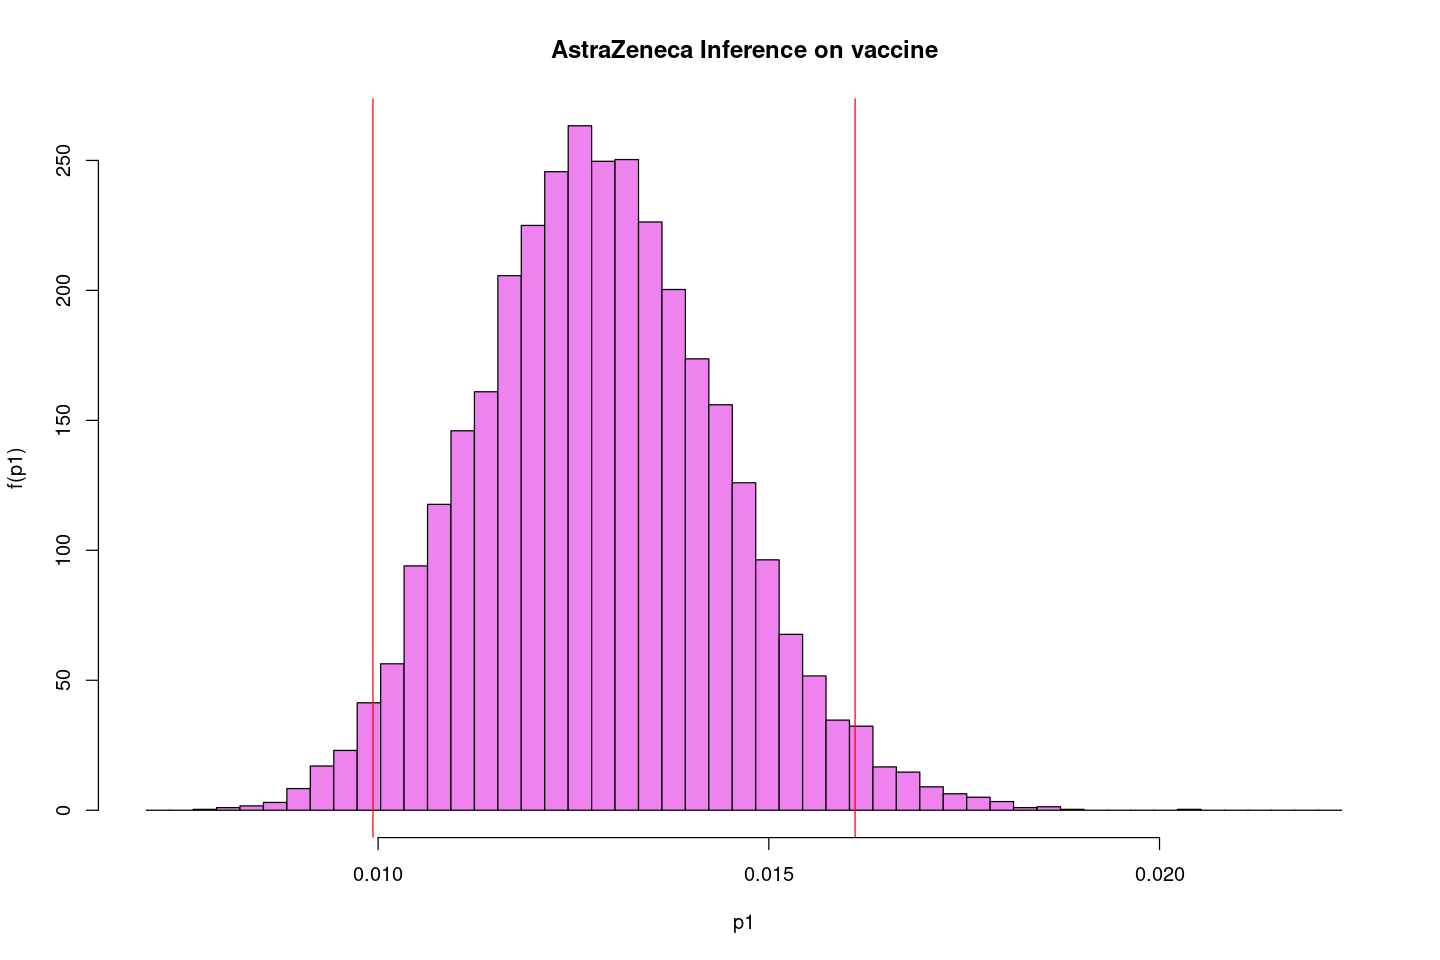

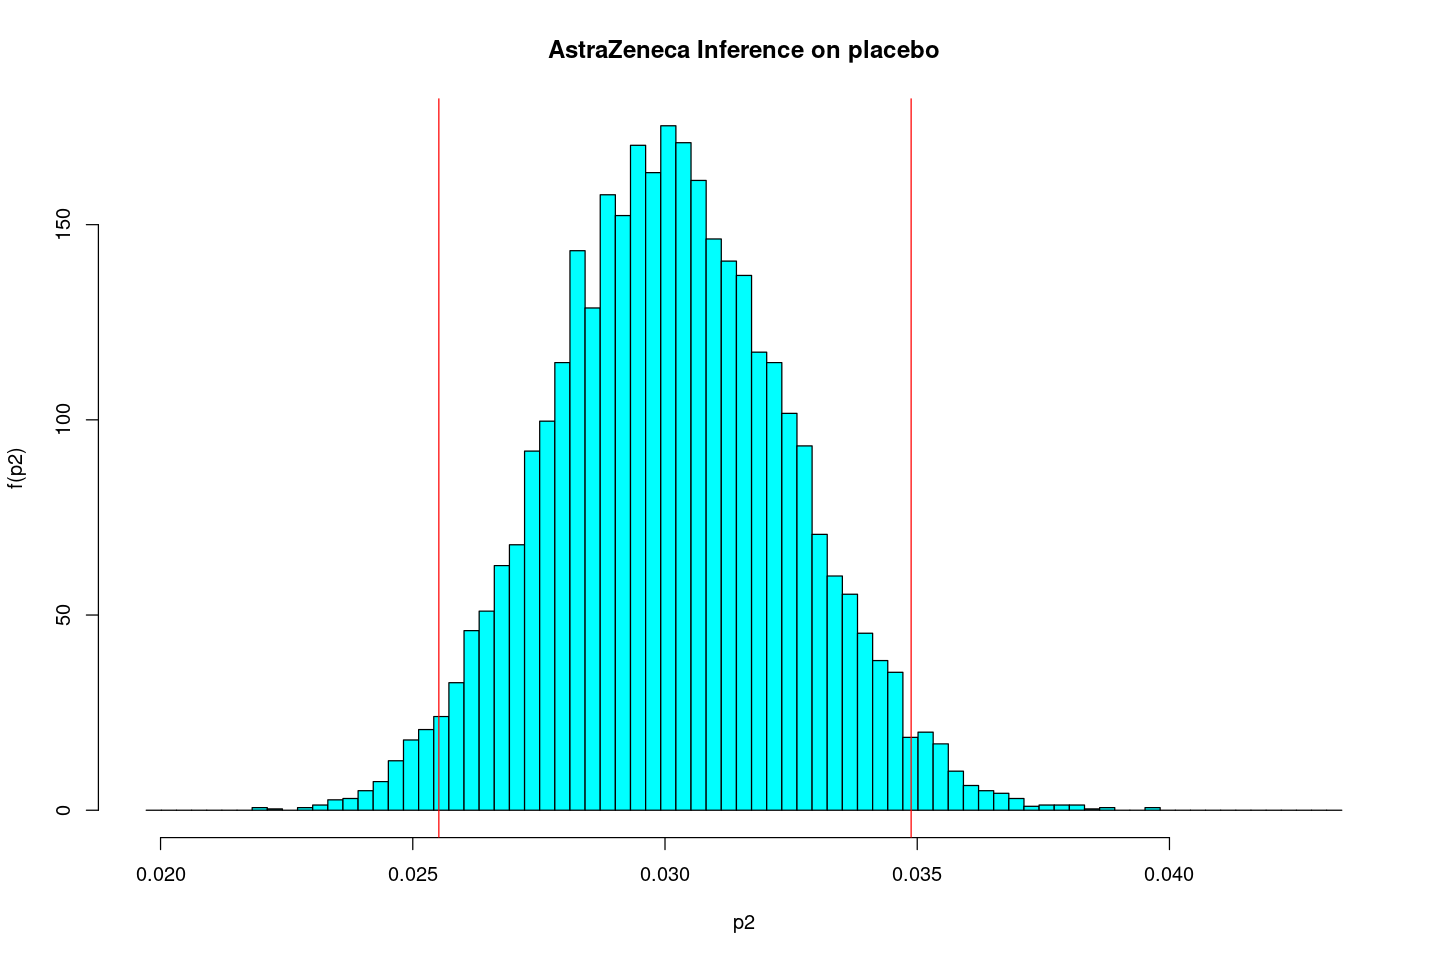

AstraZeneca vaccine efficacy =  57.05698

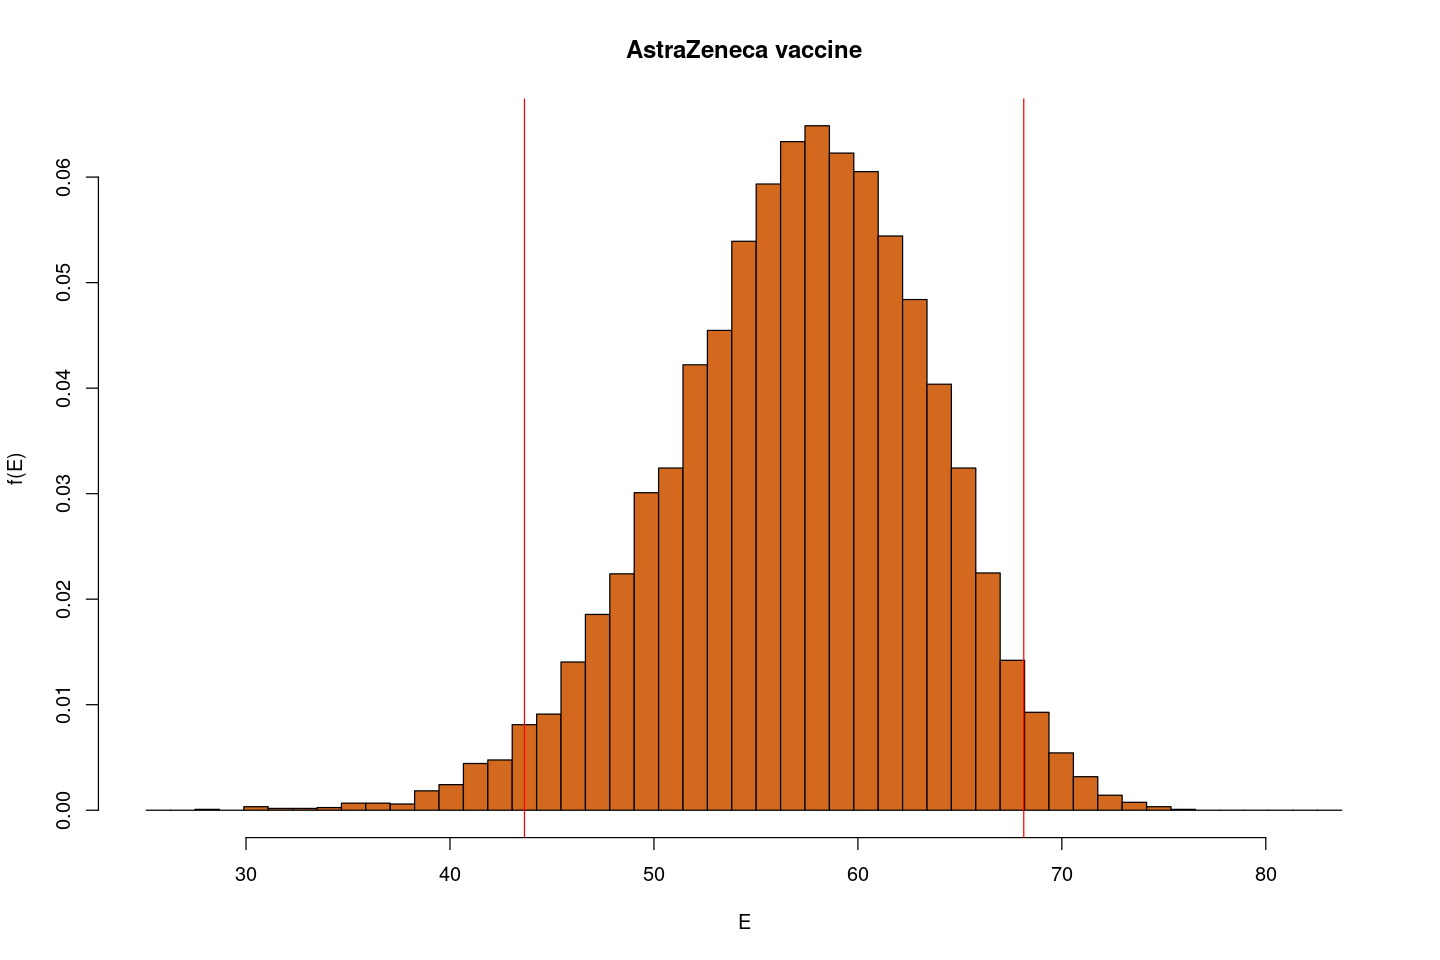

In [15]:
#jagit(Nv,vpos,Np,ppos)
A.Ef <- jagit(Nv=A.tot.vax,vpos=A.pos.vax,Np=A.tot.plb,ppos=A.pos.plb,vax.name='AstraZeneca')

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 39327

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
p1 0.006101 0.0005559 5.559e-06      5.559e-06
p2 0.017832 0.0009439 9.439e-06      9.439e-06

2. Quantiles for each variable:

       2.5%      25%      50%      75%    97.5%
p1 0.005061 0.005717 0.006093 0.006465 0.007235
p2 0.016035 0.017189 0.017806 0.018462 0.019738

Bayesian estimator:
	lambda1: 0.0061
	lambda2: 0.0176

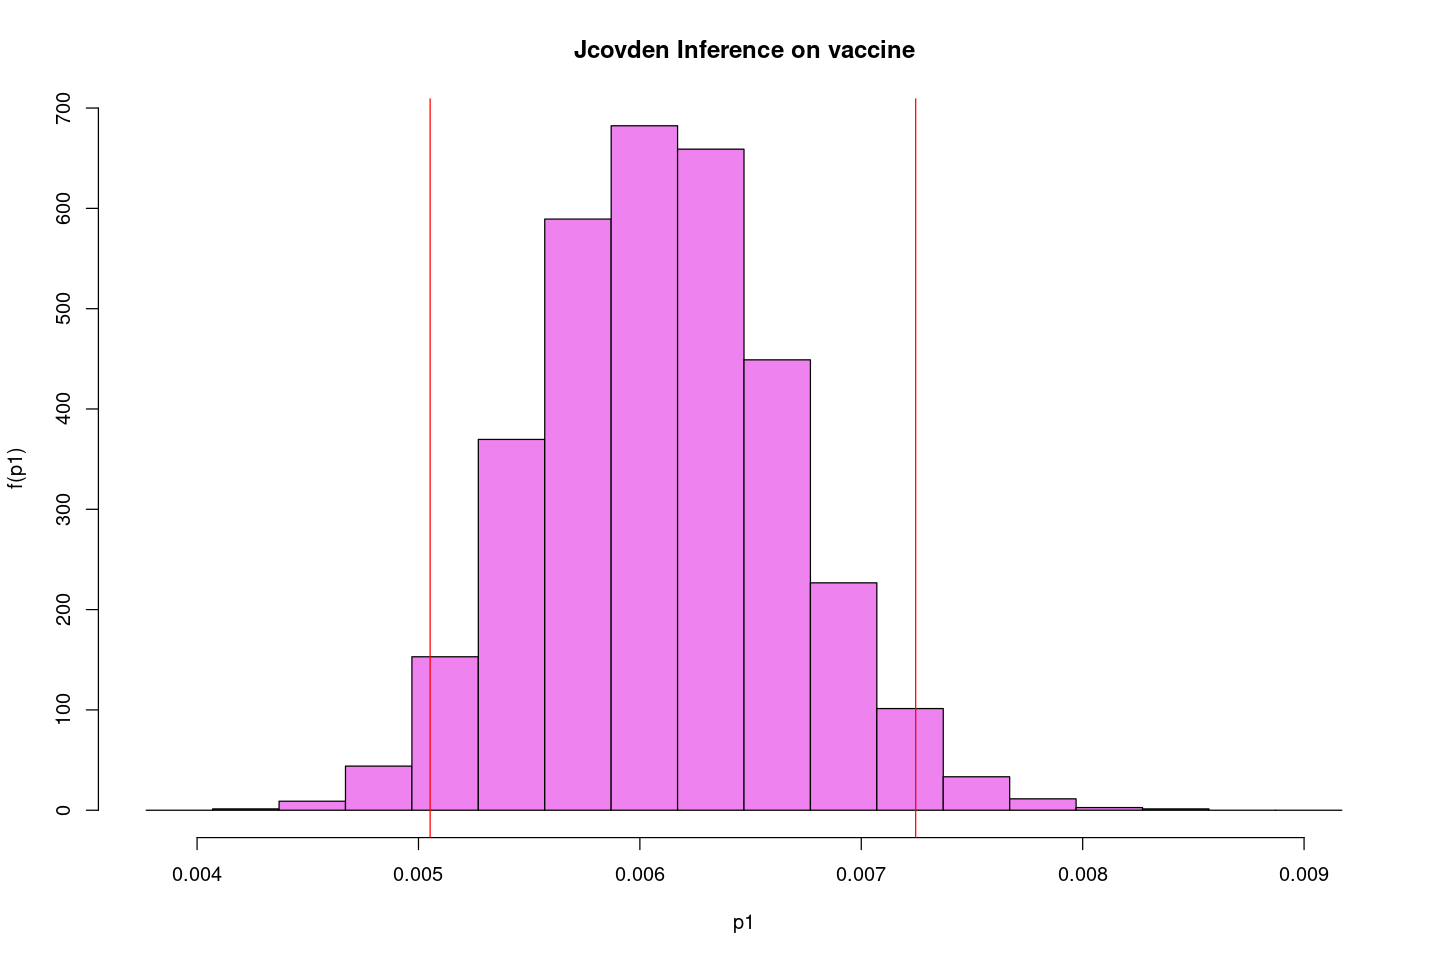

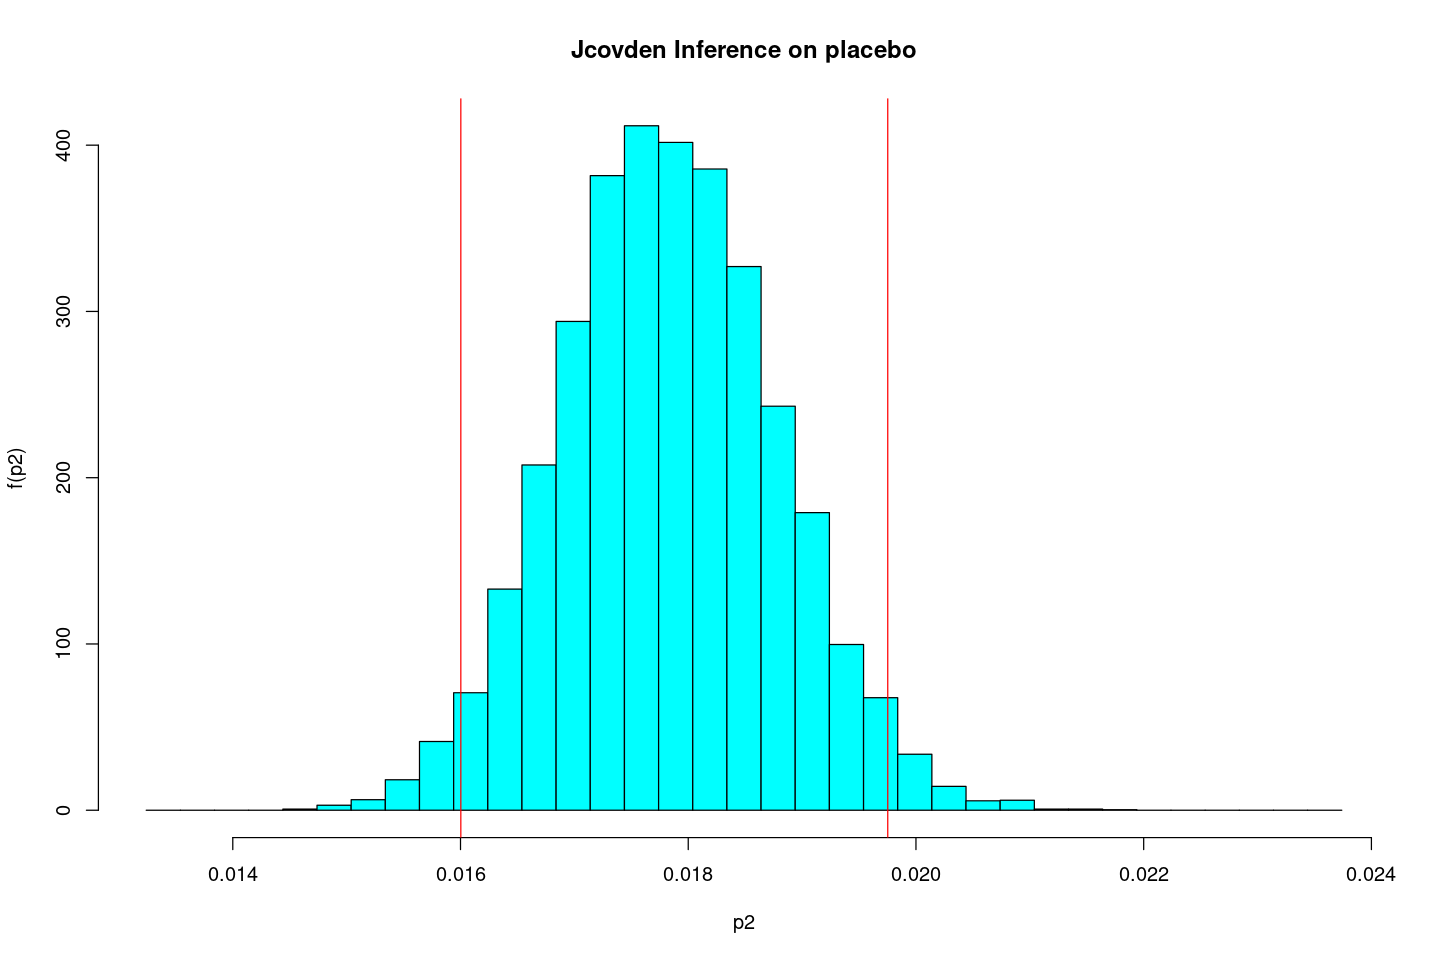

Jcovden vaccine efficacy =  65.6864

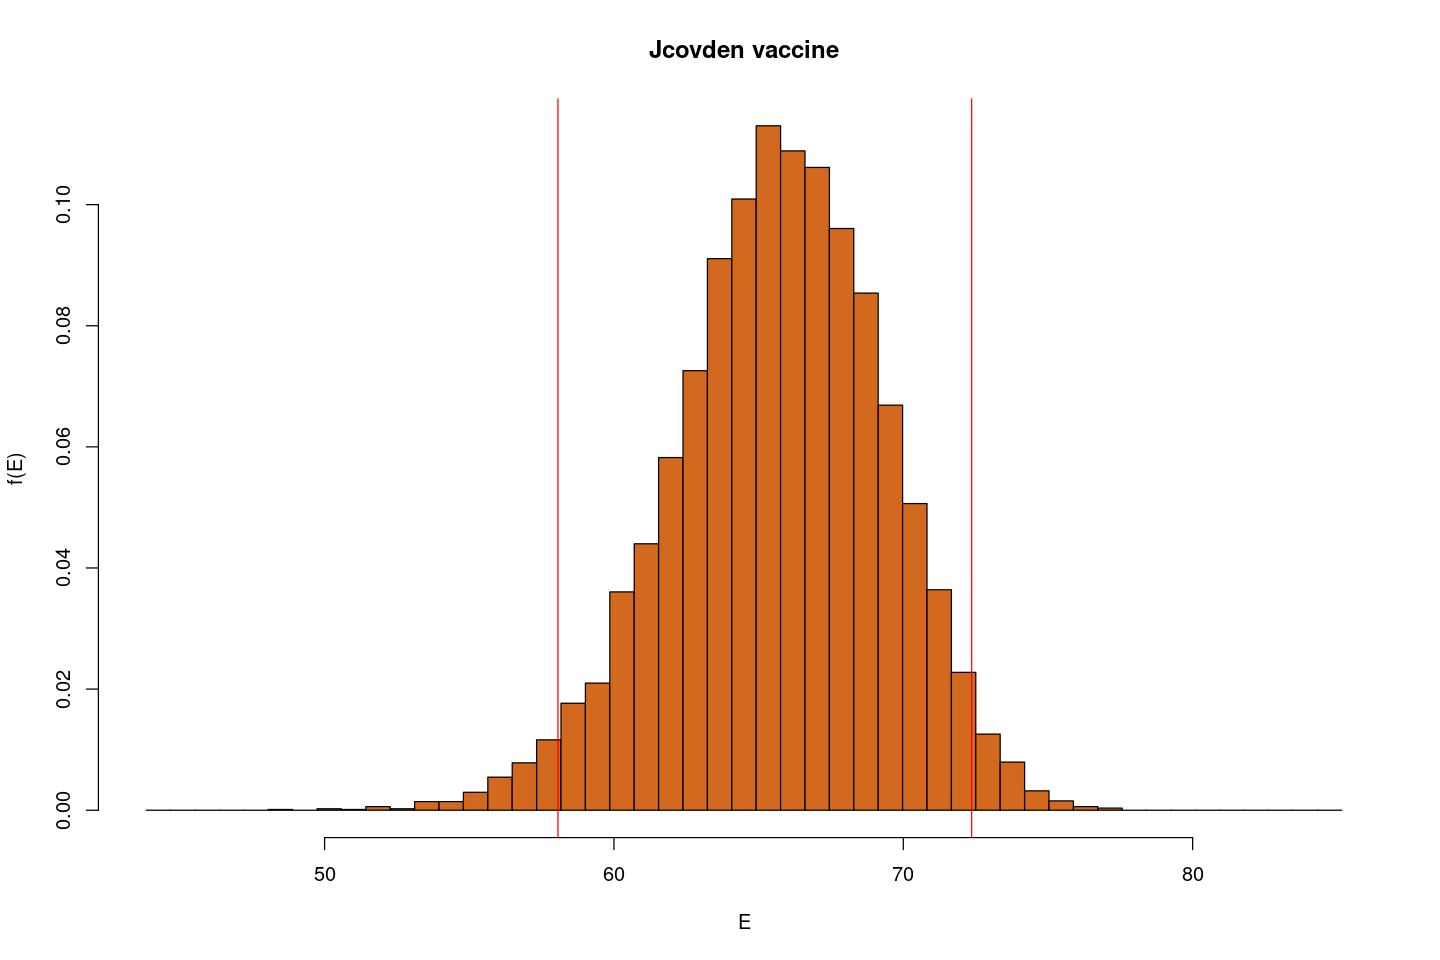

In [16]:
J.Ef <- jagit(Nv=J.tot.vax, vpos=J.pos.vax, Np=J.tot.plb, ppos=J.pos.plb, vax.name='Jcovden')

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 28213

Initializing model


Iterations = 2001:12000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

       Mean        SD  Naive SE Time-series SE
p1 0.001059 0.0002734 2.734e-06      2.734e-06
p2 0.013387 0.0009620 9.620e-06      9.340e-06

2. Quantiles for each variable:

        2.5%       25%      50%      75%    97.5%
p1 0.0005839 0.0008661 0.001036 0.001224 0.001659
p2 0.0115890 0.0127247 0.013364 0.014018 0.015339

Bayesian estimator:
	lambda1: 0.0010
	lambda2: 0.0131

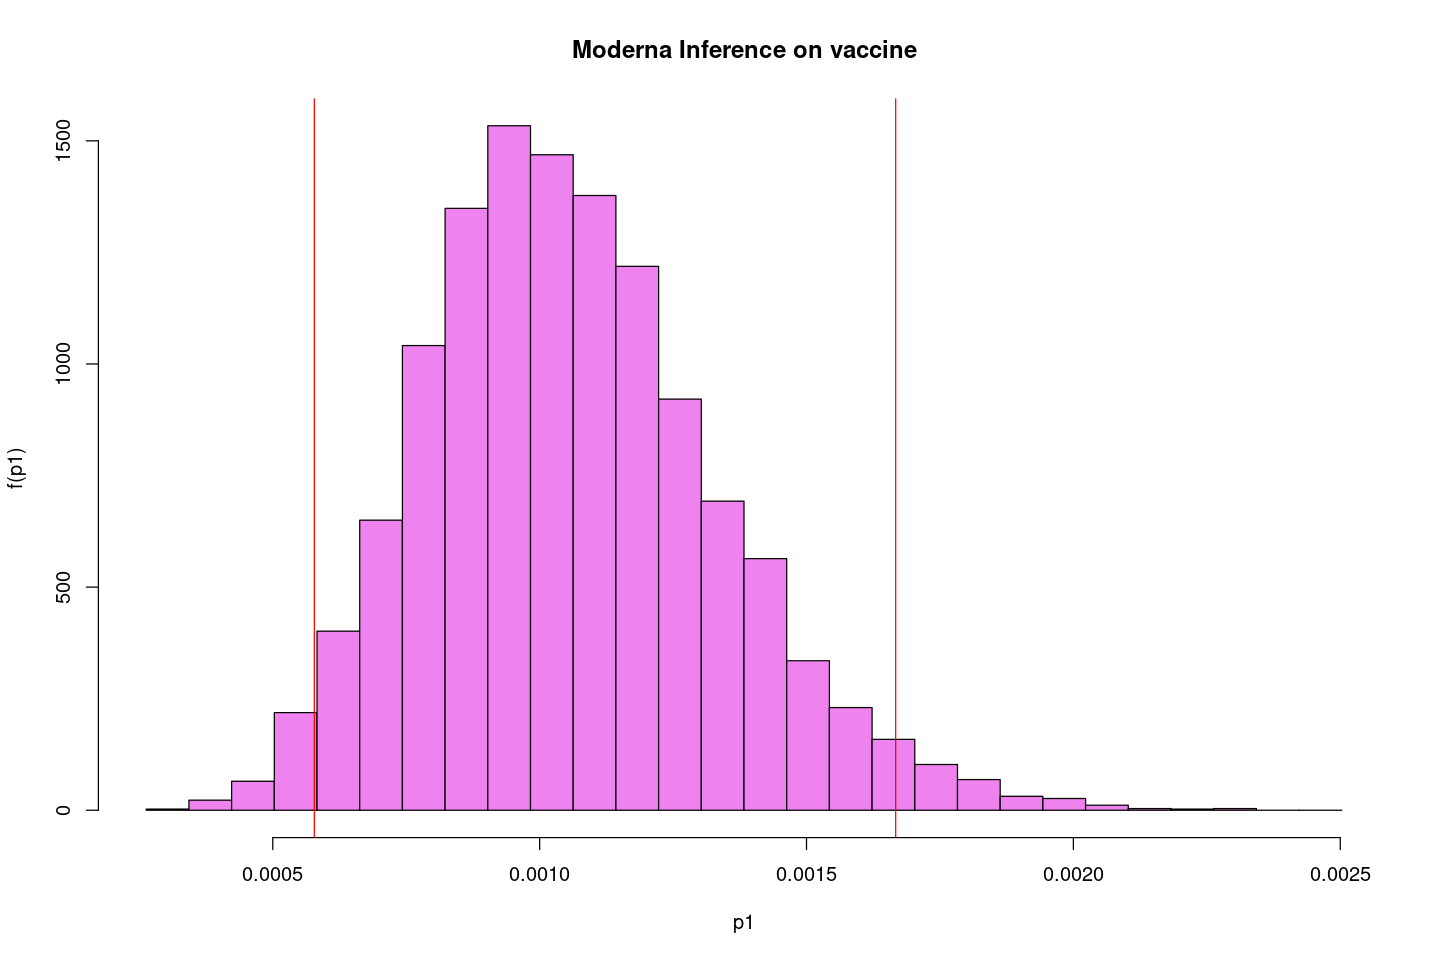

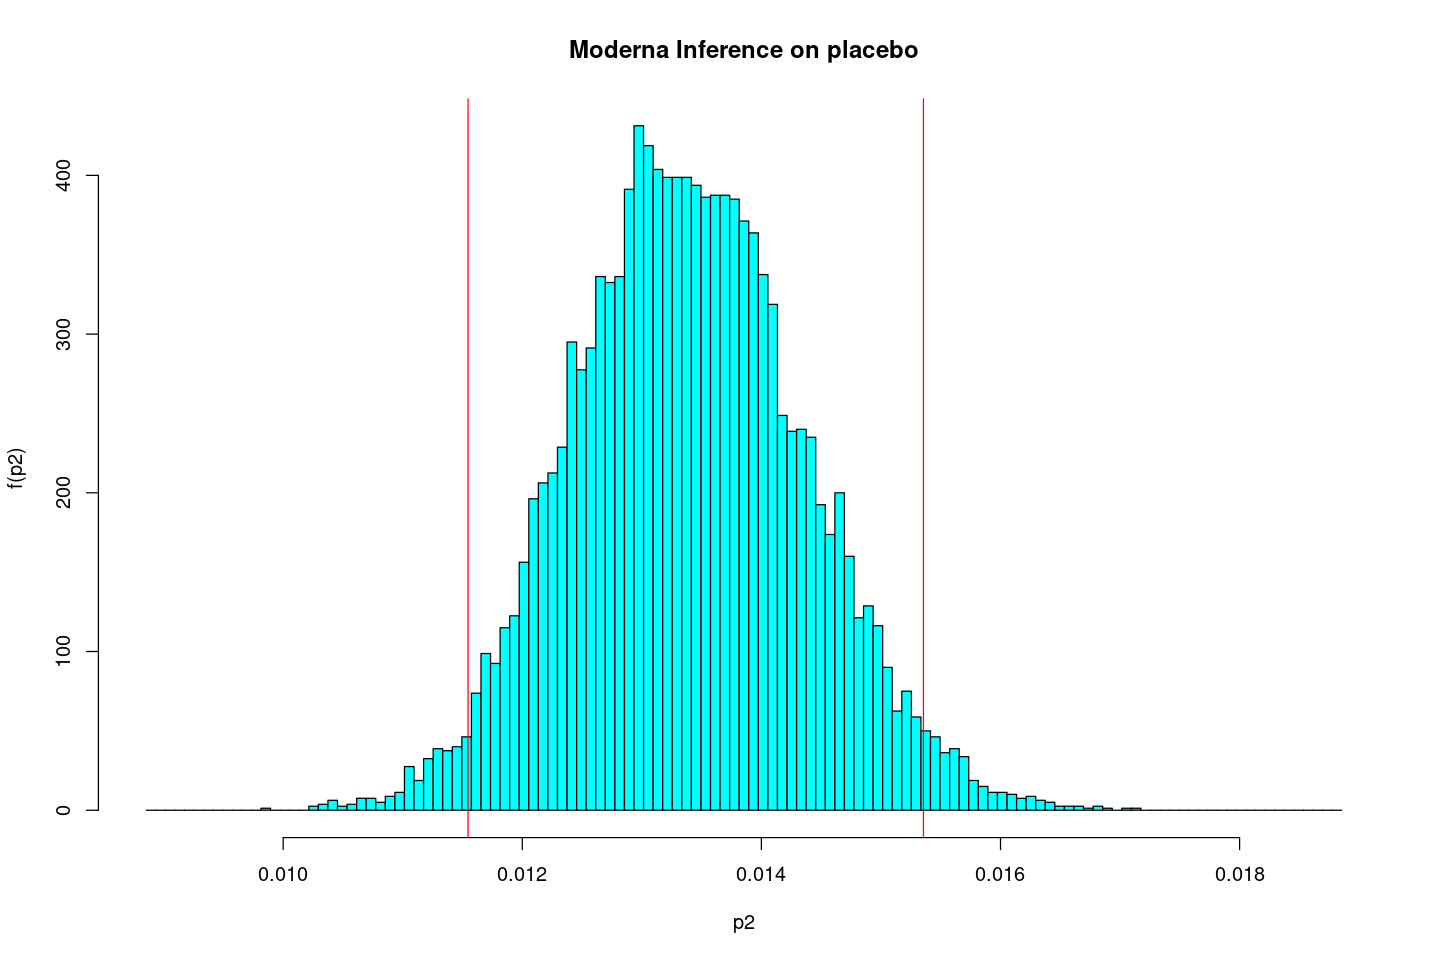

Moderna vaccine efficacy =  92.04659

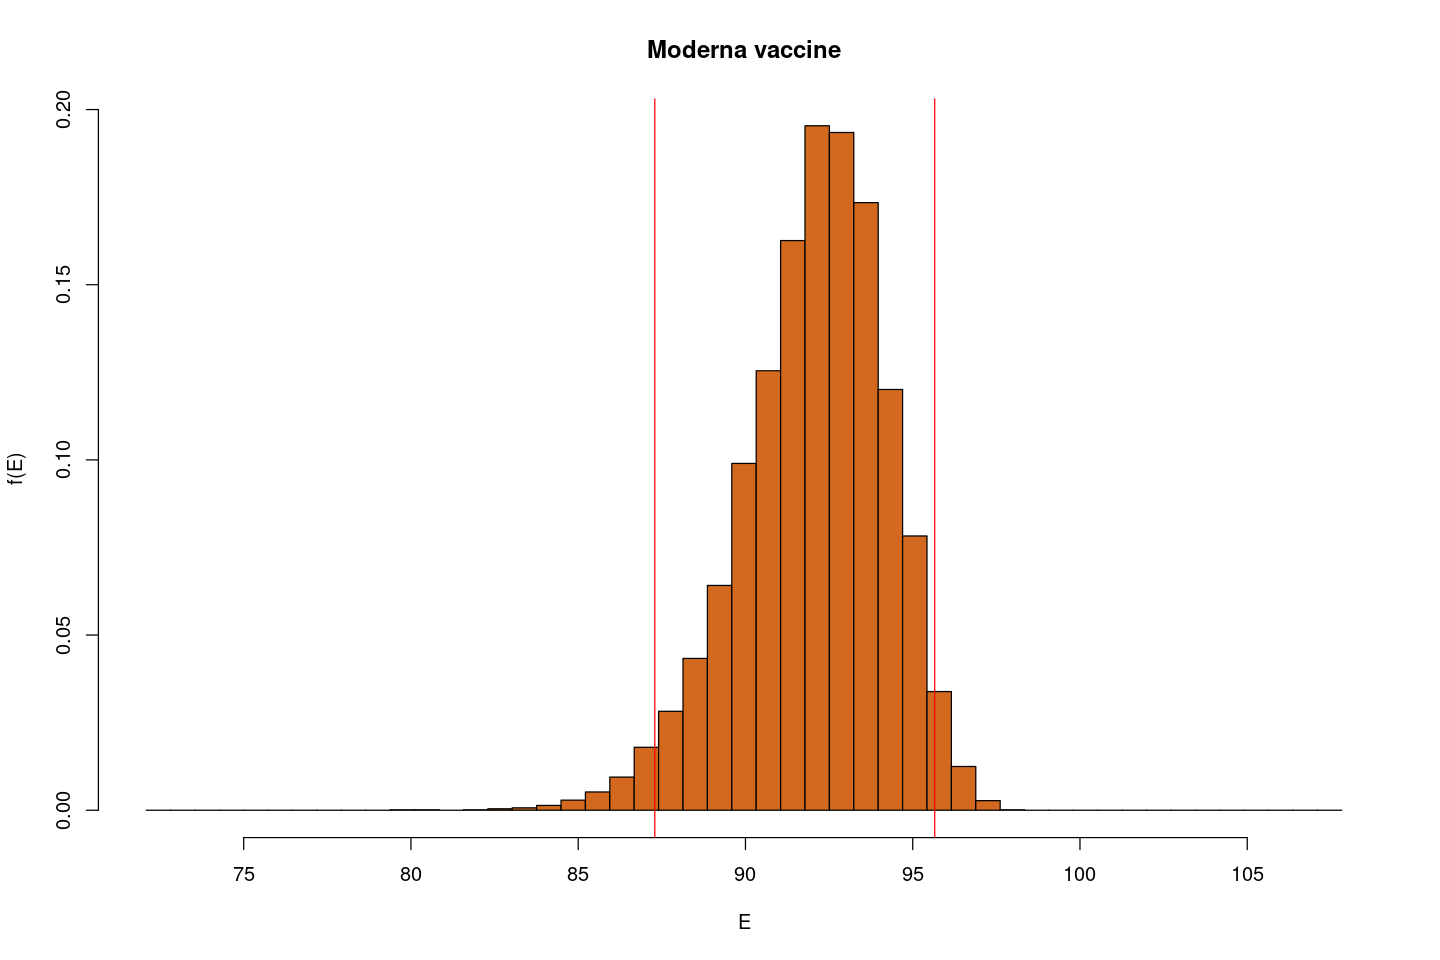

In [17]:
M.Ef <- jagit(Nv=M.tot.vax, vpos=M.pos.vax, Np=M.tot.plb, ppos=M.pos.plb, vax.name='Moderna',dbin=8e-5)

In [18]:
test.evaluate <- function(Ef,vax.name) {
    Emean <- mean(Ef) 
    Eq <- quantile(Ef, probs = c(0.025,0.975), names = FALSE,warn= TRUE)
    E.test.result <- ifelse(Emean < Eq[1], 'rejected', ifelse(Emean < Eq[2],'accepted','rejected'))
    cat('\n',vax.name,': E =',Emean,'. The efficiency claim is',E.test.result,'within the [',
        Eq[1],',',Eq[2],'] 95% CI\n')
    }

test.evaluate(A.Ef,'AstraZeneca')
test.evaluate(J.Ef,'Jcovden')
test.evaluate(M.Ef,'Moderna')


 AstraZeneca : E = 57.05698 . The efficiency claim is accepted within the [ 43.65178 , 68.13351 ] 95% CI

 Jcovden : E = 65.6864 . The efficiency claim is accepted within the [ 58.06525 , 72.36235 ] 95% CI

 Moderna : E = 92.04659 . The efficiency claim is accepted within the [ 87.28982 , 95.65726 ] 95% CI


# Exercise 3
According to the official COVID-19 vaccination data, 70% of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination [dataset](https://ourworldindata.org/covid-vaccinations) is available.

The European Centre for Disease Prevention and Control published a downloadable [file](https://github.com/owid/covid-19-data/tree/master/public/data)  containing
information on COVID-19 vaccination in the EU/EEA.

Analyze the data and produce the following plots:
1. number of vaccinated people (cumulative, daily and week average)
2. number of confirmed deaths by COVID-19, both cumulative and weekly average

In [19]:
w.path = 'owid-covid-data.csv'

all.df = read.csv(w.path,header=TRUE,sep=',')

In [20]:
World.byweek <- all.df %>% subset(location == "World") %>% 
               group_by(year=year(date), week=week(date)) %>% 
               summarise(date = as.Date(min(date)),
                         vaccinated = mean(new_vaccinations, na.rm=TRUE),
                         dead = mean(new_deaths, na.rm=TRUE)) %>%
               ungroup(year) %>% 
               select(date, vaccinated, dead) 

World.byday <- all.df %>% subset(location == "World")

head(World.byday)

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,⋯,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
309932,OWID_WRL,,World,2020-01-03,NA,0,NA,NA,0,NA,⋯,34.635,60.13,2.705,72.58,0.737,7975105024,NA,NA,NA,NA
309933,OWID_WRL,,World,2020-01-04,3,3,NA,NA,0,NA,⋯,34.635,60.13,2.705,72.58,0.737,7975105024,NA,NA,NA,NA
309934,OWID_WRL,,World,2020-01-05,3,0,NA,NA,0,NA,⋯,34.635,60.13,2.705,72.58,0.737,7975105024,NA,NA,NA,NA
309935,OWID_WRL,,World,2020-01-06,6,3,NA,NA,0,NA,⋯,34.635,60.13,2.705,72.58,0.737,7975105024,NA,NA,NA,NA
309936,OWID_WRL,,World,2020-01-07,6,0,NA,NA,0,NA,⋯,34.635,60.13,2.705,72.58,0.737,7975105024,NA,NA,NA,NA
309937,OWID_WRL,,World,2020-01-08,7,1,1,NA,0,0,⋯,34.635,60.13,2.705,72.58,0.737,7975105024,NA,NA,NA,NA


Warning message:
“Removed 49 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 49 rows containing missing values (`geom_line()`).”


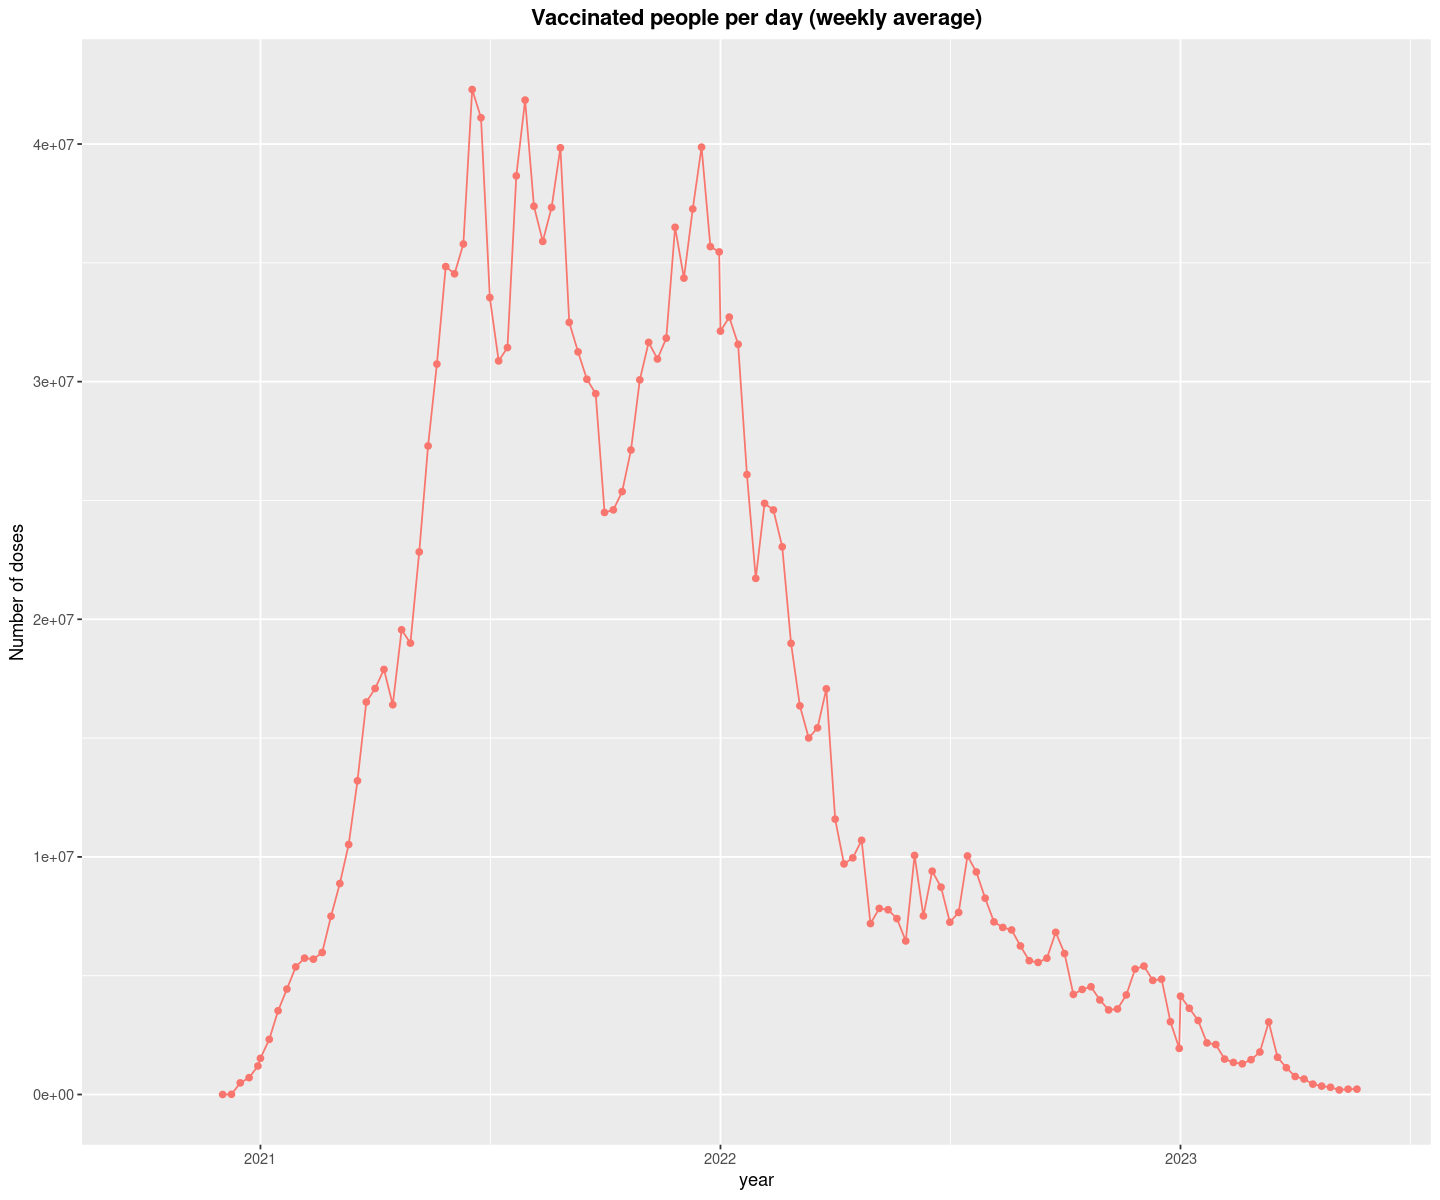

In [21]:
options(repr.plot.width=12, repr.plot.height=10)

v_byweek  <- ggplot(World.byweek, aes(x = date, y = vaccinated, color = 'black')) +
             geom_point() +
             geom_line() +
             xlim(as.Date('2020-09-30'),as.Date('2023-5-31')) +
             labs(title="Vaccinated people per day (weekly average)",x="year", y="Number of doses") +
             theme(plot.title = element_text(hjust=0.5, face='bold'), legend.position='topright')

v_byweek

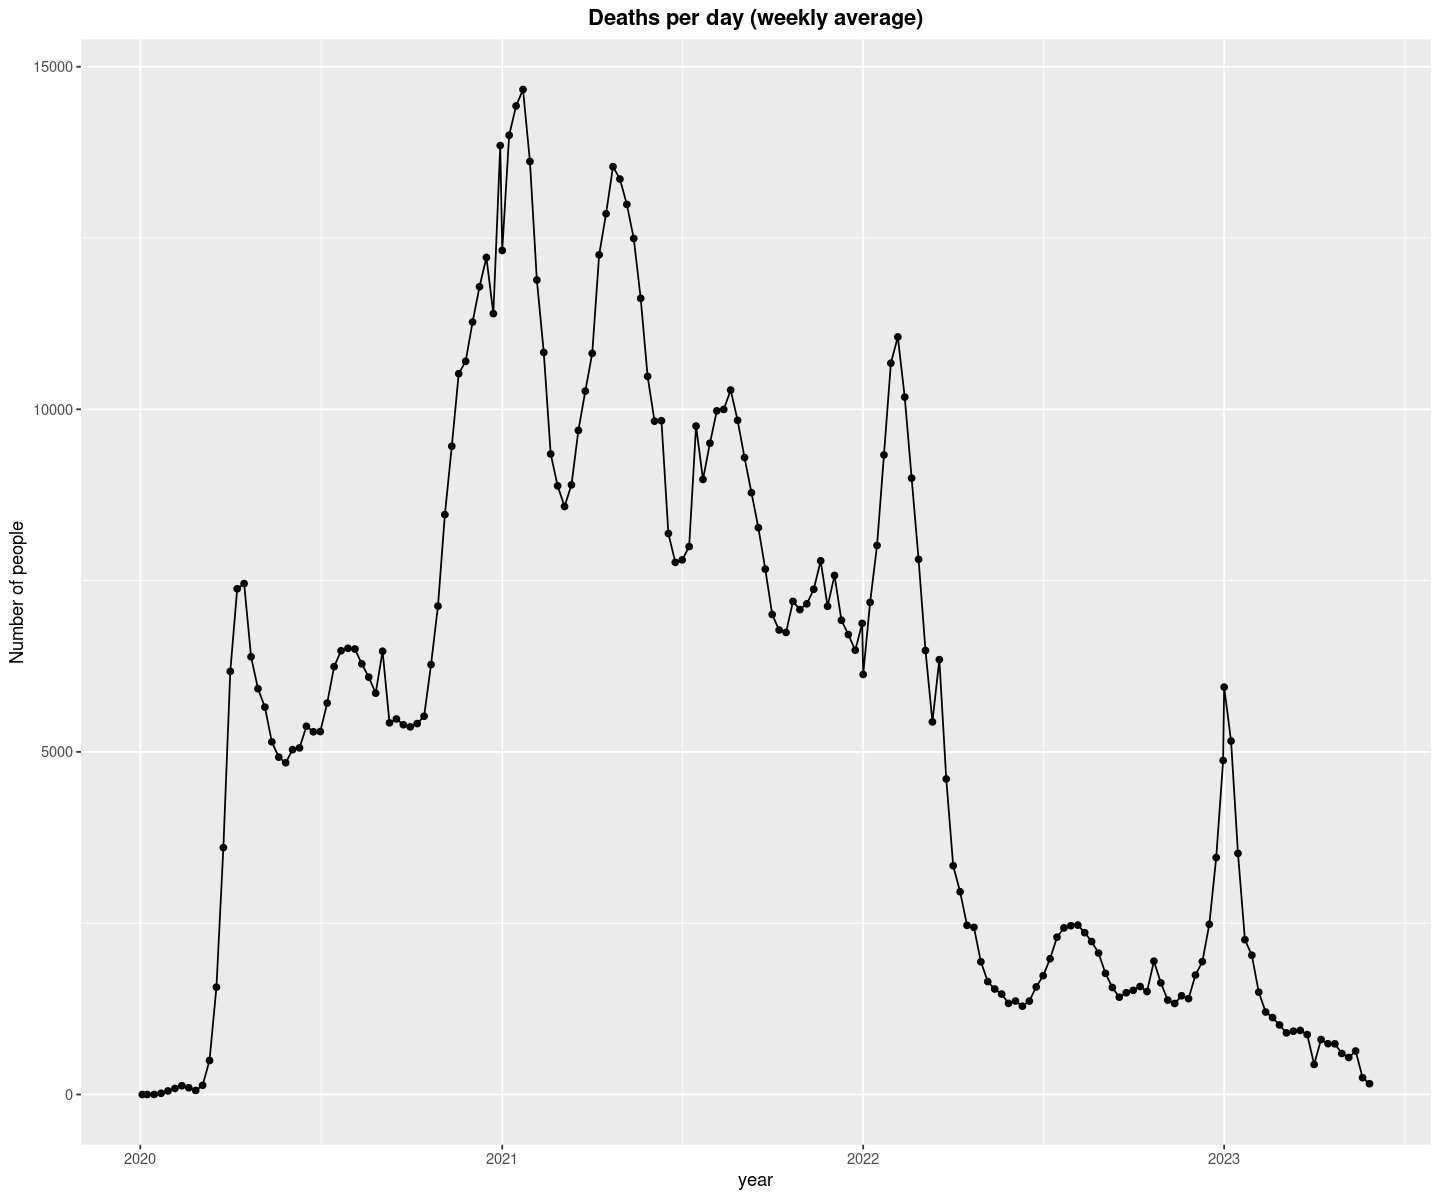

In [22]:
d_byweek  <- ggplot(World.byweek, aes(x = date, y = dead)) +
             geom_point() +
             geom_line() +
             labs(title="Deaths per day (weekly average)",x="year", y="Number of people") +
             theme(plot.title = element_text(hjust=0.5, face='bold'), legend.position='topright')

d_byweek

Warning message:
“Removed 336 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 336 rows containing missing values (`geom_line()`).”


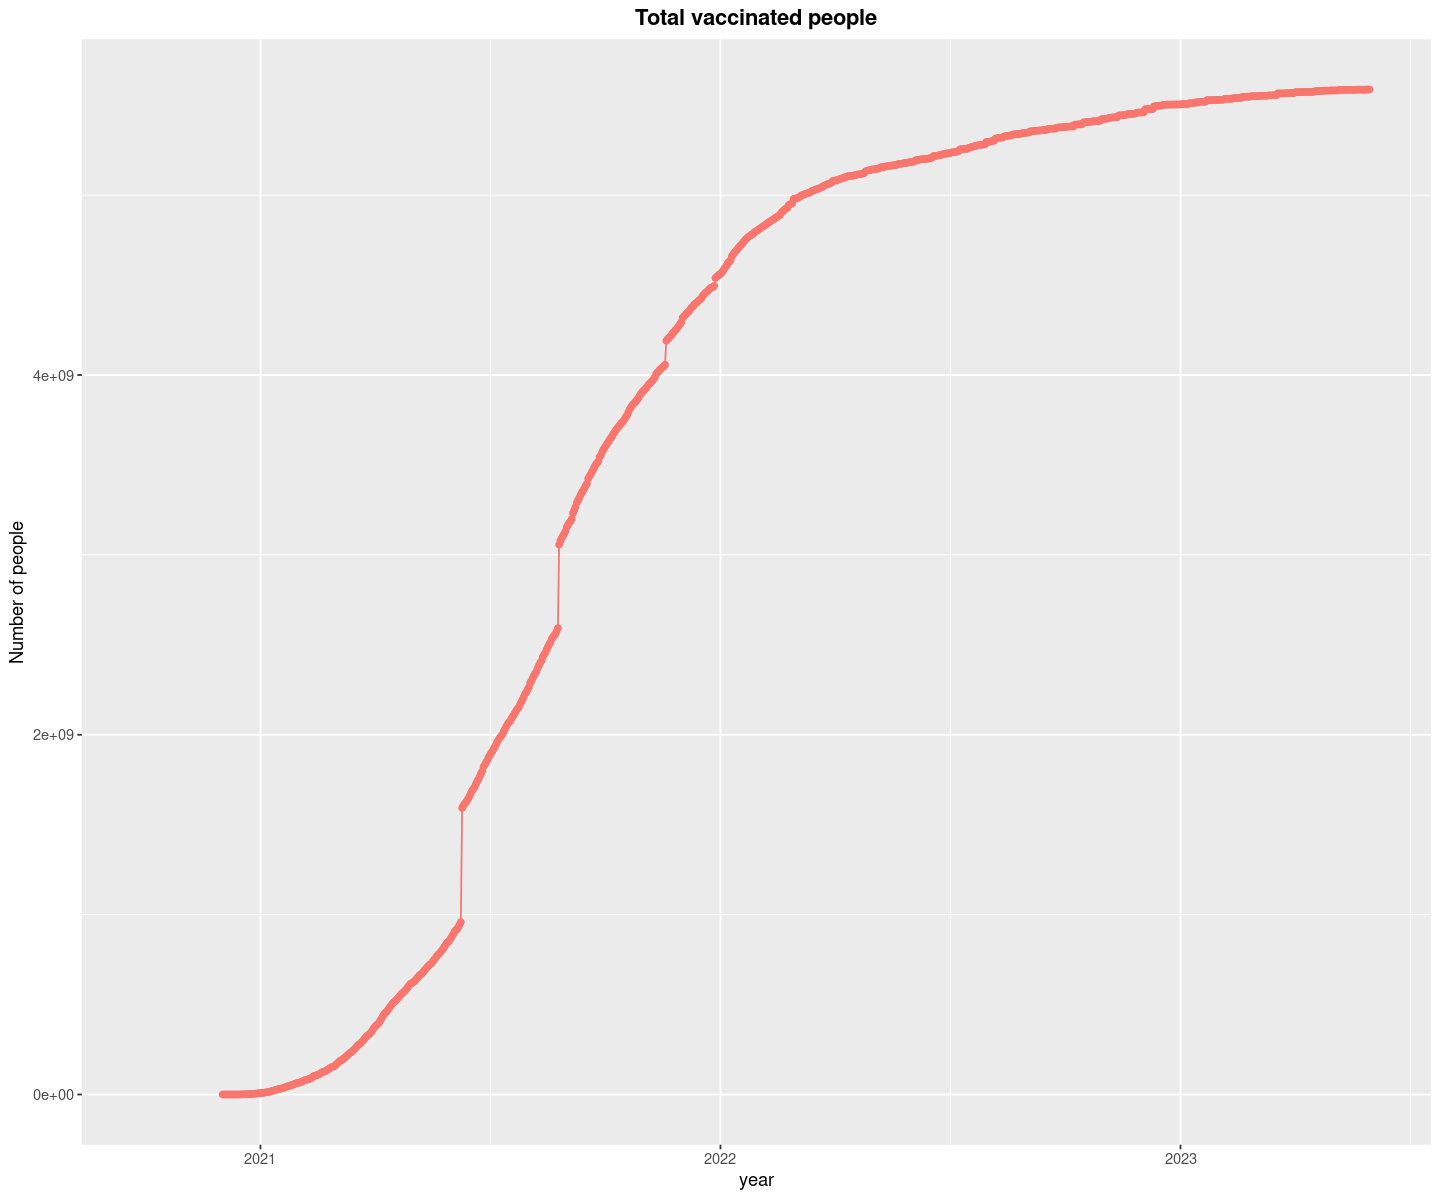

In [23]:
vcum_byday  <- ggplot(World.byday, aes(x = as.Date(date), y = people_vaccinated, color = 'black')) +
             geom_point() +
             geom_line() +
             xlim(as.Date('2020-09-30'),as.Date('2023-5-31')) +
             labs(title="Total vaccinated people", x="year", y="Number of people") +
             theme(plot.title = element_text(hjust=0.5, face='bold'), legend.position='topright')

vcum_byday

Warning message:
“Removed 340 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 340 rows containing missing values (`geom_line()`).”


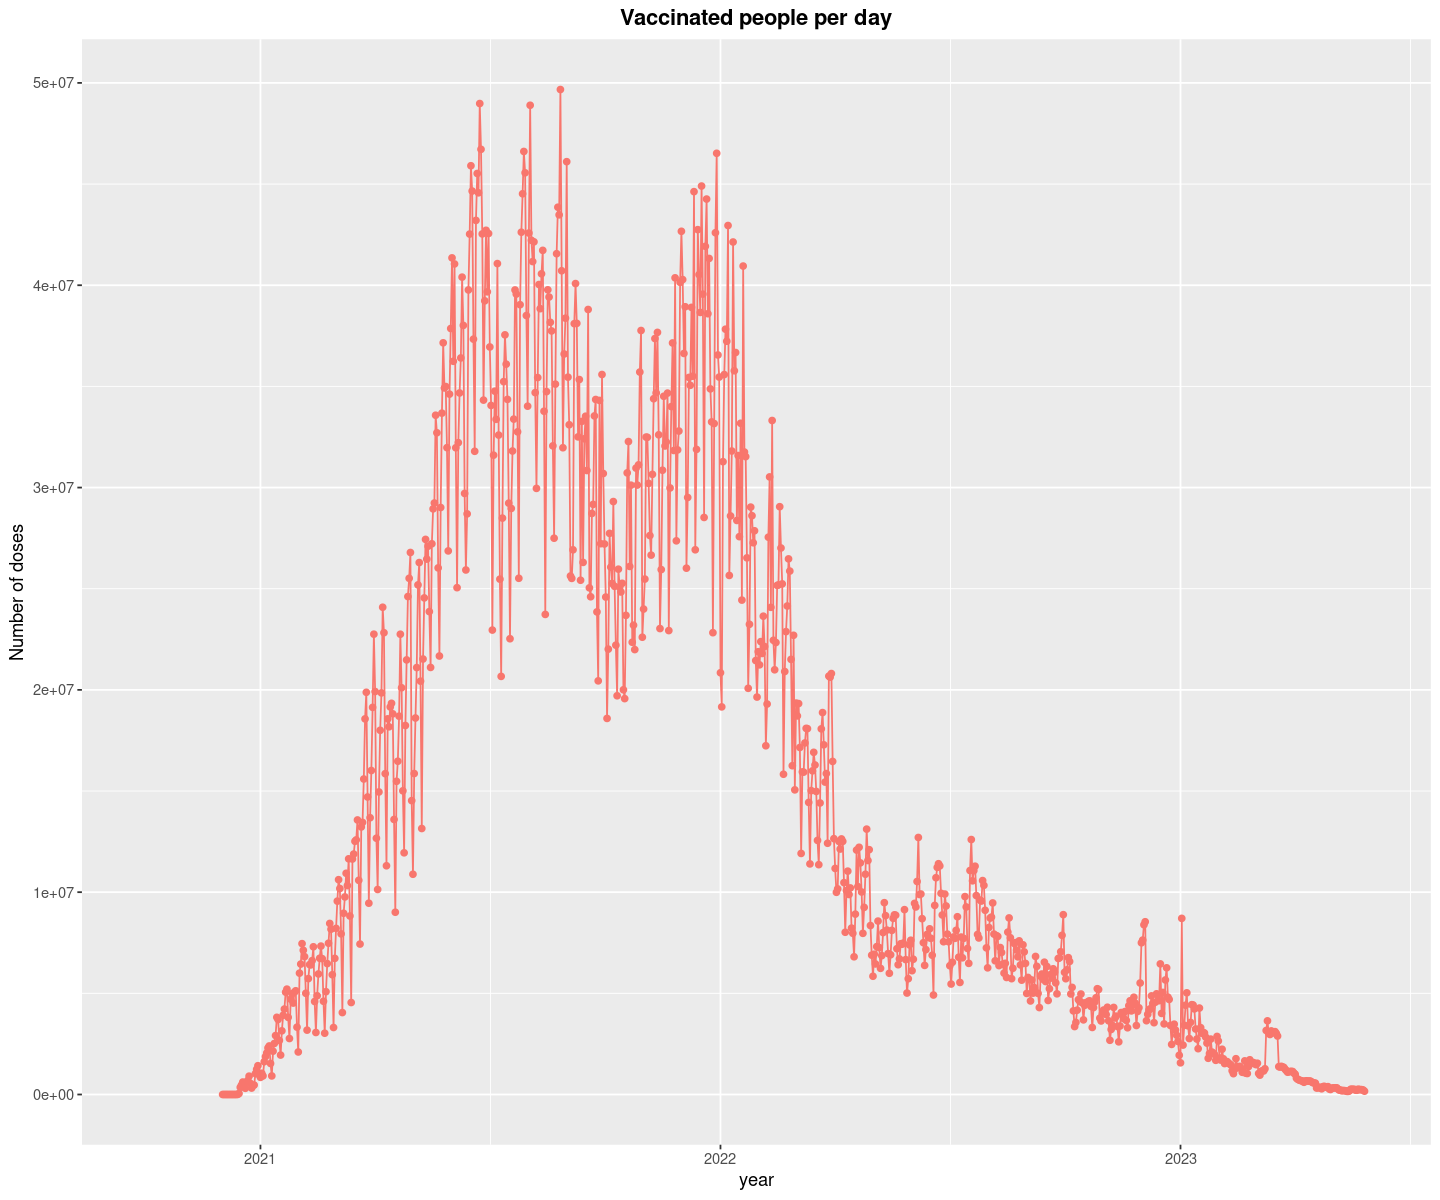

In [24]:
v_byday  <- ggplot(World.byday, aes(x = as.Date(date), y = new_vaccinations, color = 'black')) +
             geom_point() +
             geom_line() +
             xlim(as.Date('2020-09-30'),as.Date('2023-5-31')) +
             labs(title="Vaccinated people per day",x="year", y="Number of doses") +
             theme(plot.title = element_text(hjust=0.5, face='bold'), legend.position='topright')

v_byday

Warning message:
“Removed 11 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 11 rows containing missing values (`geom_line()`).”


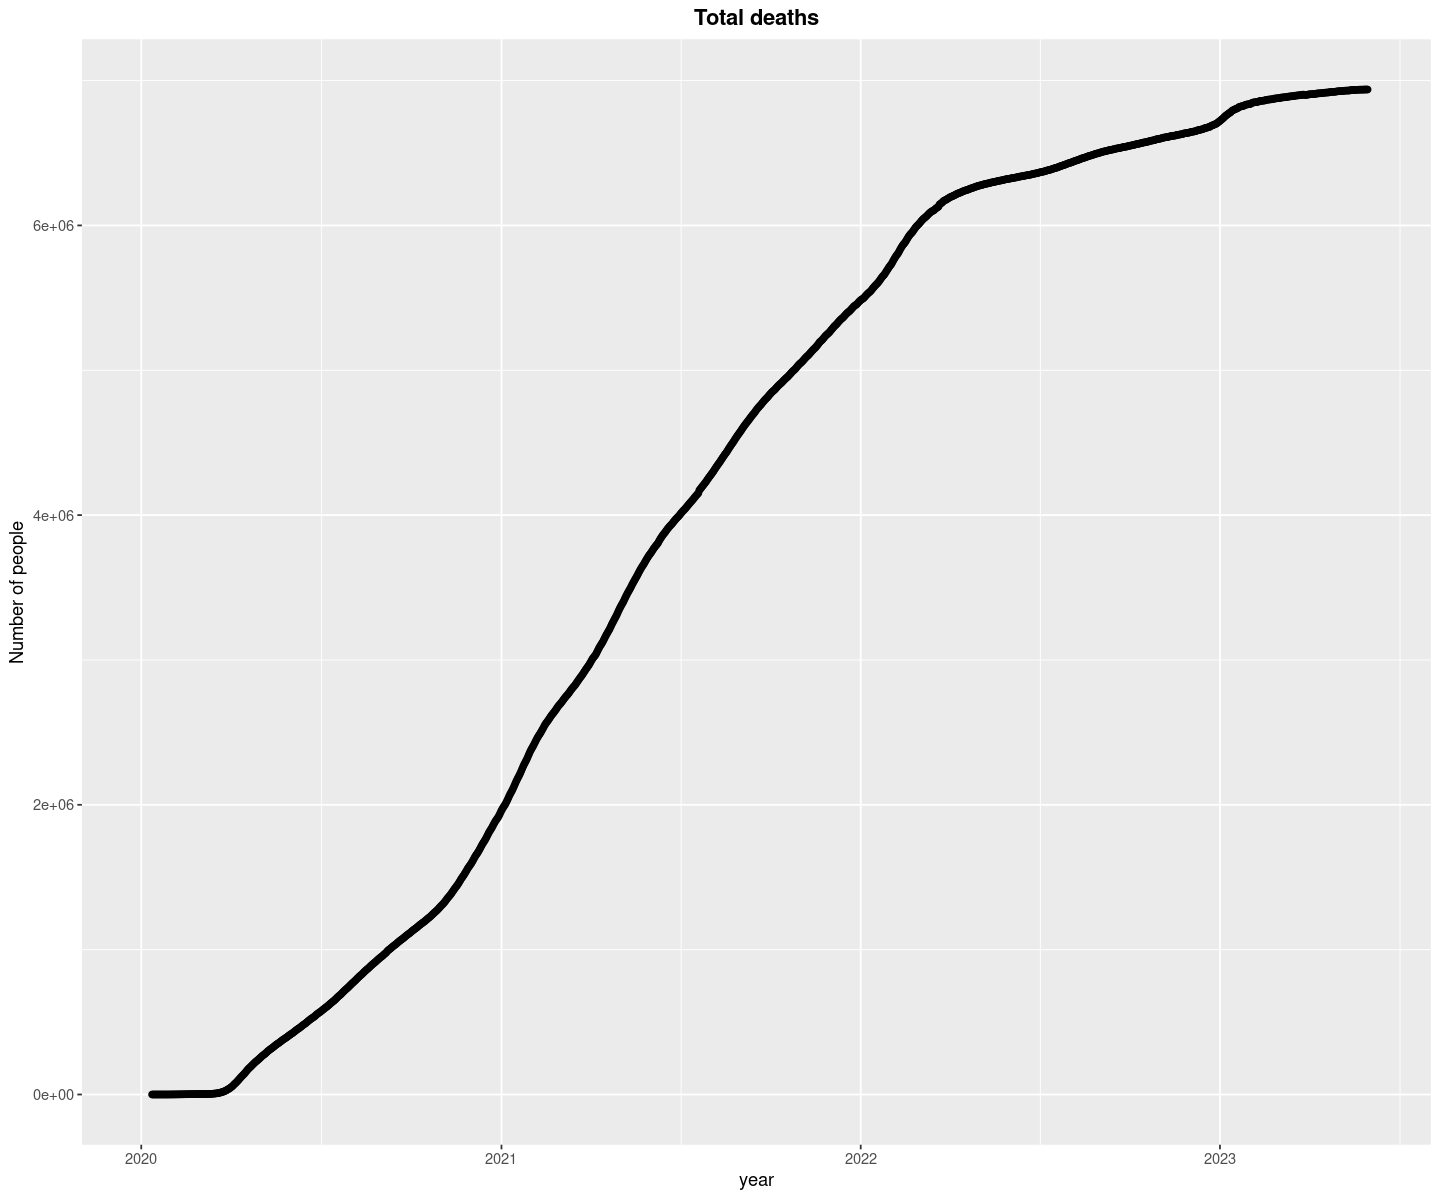

In [25]:
dcum_byday  <- ggplot(World.byday, aes(x = as.Date(date), y = total_deaths)) +
             geom_point() +
             geom_line() +
             labs(title="Total deaths", x="year",y="Number of people") +
             theme(plot.title = element_text(hjust=0.5, face='bold'), legend.position='topright')

dcum_byday